<a href="https://colab.research.google.com/github/mickvanhulst/twitter_bitcoin_analysis/blob/master/CNN_btc_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

!pip install git+git://github.com/mickvanhulst/livelossplot.git --upgrade

0.4.0
True
  Cloning git://github.com/mickvanhulst/livelossplot.git to /tmp/pip-req-build-45is6wzm
  Running setup.py bdist_wheel for livelossplot ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-59d46c_b/wheels/73/e2/09/79ee9f5b0be18dc9c6ee17f0dc181708c1cf9513c70053ca92
Successfully built livelossplot
  Found existing installation: livelossplot 0.2.2
    Uninstalling livelossplot-0.2.2:
      Successfully uninstalled livelossplot-0.2.2


# Test if GPU enabled

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Load packages

In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as utils

# from livelossplot import PlotLosses
import matplotlib
import matplotlib.pyplot as plt

from google.colab import drive

import numpy as np
import time
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import os

# Mount Drive and open matrices

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import re

def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    
    amazing <3 RegExp
    """
    l.sort(key=alphanum_key)
    return l

In [0]:
model_type = ['keywords_tfidf_p', 'keywords_tfidf', 'keywords_clusters'][1]
mode = ['count', 'binary'][0]
INPUT_SIZE_CNN = 25 if model_type == 'keywords_clusters' else 1000
train, test = None, None

In [7]:
train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t = None, None, None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/train/'.format(model_type, mode)
files = os.listdir(base_str)
for train_file in sort_nicely(files):
    if 'btc' in train_file:
        temp = np.load(base_str + train_file)
        if train_btc_meta_data is None:
            train_btc_meta_data = temp
        else:
            train_btc_meta_data = np.concatenate((train_btc_meta_data, temp), axis=0)
    elif 'tc_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes_t is None:
            train_classes_t = temp
        else:
            train_classes_t = np.concatenate((train_classes_t, temp), axis=0)
    elif 'c_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes is None:
            train_classes = temp
        else:
            train_classes = np.concatenate((train_classes, temp), axis=0)
    elif 'md_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_user_data is None:
            train_user_data = temp
        else:
            train_user_data = np.vstack((train_user_data, temp))
    elif 'dp_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_matrices is None:
            train_matrices = temp
        else:
            train_matrices = np.vstack((train_matrices, temp))
    elif 'dt_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_dates is None:
            train_dates = temp
        else:
            train_dates = np.concatenate((train_dates, temp), axis=0)

print('Train shapes: ', train_classes_t.shape, train_classes.shape, train_user_data.shape, 
      train_matrices.shape, train_dates.shape, train_btc_meta_data.shape)

Train shapes:  (36380,) (36380,) (36380, 8) (36380, 1000, 7) (36380,) (36380, 8)


In [8]:
test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = None, None, None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/test/'.format(model_type, mode)

for test_file in sort_nicely(os.listdir(base_str)):
    if 'btc' in test_file:
        temp = np.load(base_str + test_file)
        if test_btc_meta_data is None:
            test_btc_meta_data = temp
        else:
            test_btc_meta_data = np.concatenate((test_btc_meta_data, temp), axis=0)
    elif 'tc_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes_t is None:
            test_classes_t = temp
        else:
            test_classes_t = np.concatenate((test_classes_t, temp), axis=0)
    elif 'c_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes is None:
            test_classes = temp
        else:
            test_classes = np.concatenate((test_classes, temp), axis=0)
    elif 'md_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_user_data is None:
            test_user_data = temp
        else:
            test_user_data = np.vstack((test_user_data, temp))
    elif 'dp_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_matrices is None:
            test_matrices = temp
        else:
            test_matrices = np.vstack((test_matrices, temp))
    elif 'dt_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_dates is None:
            test_dates = temp
        else:
            test_dates = np.concatenate((test_dates, temp), axis=0)
            
print('Test shapes: ', test_classes_t.shape, test_classes.shape, test_user_data.shape, 
      test_matrices.shape, test_dates.shape, test_btc_meta_data.shape)

Test shapes:  (6223,) (6223,) (6223, 8) (6223, 1000, 7) (6223,) (6223, 8)


In [0]:
# Re-assign tokens for userIds as this makes normalization easier (no precision errors).
unique_users = np.unique(np.concatenate((np.unique(train_user_data[:,-1]), np.unique(test_user_data[:,-1]))))
user_ids = {}
for i, v in enumerate(unique_users):
    user_ids[v] = (i+1)

for i, v in enumerate(train_user_data):
    train_user_data[i,-1] = user_ids[v[-1]]
    
for i, v in enumerate(test_user_data):
    test_user_data[i,-1] = user_ids[v[-1]]

In [0]:
scaler = StandardScaler()
scaler.fit(train_user_data)
train_user_data = scaler.transform(train_user_data)
test_user_data = scaler.transform(test_user_data)

In [0]:
# scalers = {}
# for i in range(train_btc_meta_data.shape[2]):
#     scalers[i] = StandardScaler()
#     train_btc_meta_data[:, i, :] = scalers[i].fit_transform(train_btc_meta_data[:, i, :]) 

# for i in range(test_btc_meta_data.shape[2]):
#     test_btc_meta_data[:, i, :] = scalers[i].transform(test_btc_meta_data[:, i, :]) 

In [0]:
scalers = {}
for i in range(train_matrices.shape[2]):
    scalers[i] = StandardScaler()
    train_matrices[:, i, :] = scalers[i].fit_transform(train_matrices[:, i, :]) 

for i in range(test_matrices.shape[2]):
    test_matrices[:, i, :] = scalers[i].transform(test_matrices[:, i, :]) 

# Some analysis

## Feature analysis

In [0]:
'''
Calculates feature importance for each feature on a day-by-day basis.

This way we can evaluate which feature of a particular day is important
in comparison to the class result.
'''

from sklearn.feature_selection import mutual_info_classif

# Calculate impact of features on classes separately.
train_mi = {}
train_mi_tc = {}
for i in range(train_matrices.shape[2]):
    train_mi[i] = mutual_info_classif(train_matrices[:, :, i], train_classes)
    train_mi_tc[i] = mutual_info_classif(train_matrices[:, :, i], train_classes_t)
    print('Done {}'.format(i / train_matrices.shape[2]))

np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/train_mi_c.npy', np.array(train_mi))
np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/train_mi_tc.npy', np.array(train_mi_tc))

Done 0.0
Done 0.14285714285714285
Done 0.2857142857142857
Done 0.42857142857142855
Done 0.5714285714285714
Done 0.7142857142857143
Done 0.8571428571428571


In [0]:

np.sum(np.sum(train_mi_tc[i] for i in range(7)))

0.8319400209859054

## Check distribution of nonzeroes for training matrices and test data

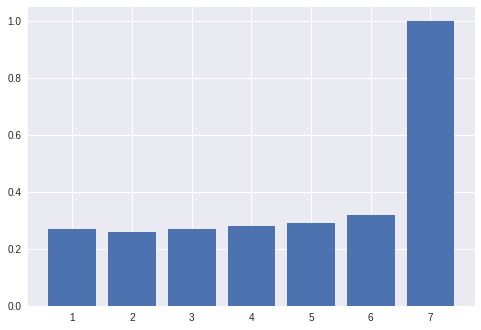

[49130, 32207, 21824, 14793, 13843, 6862, 5919]


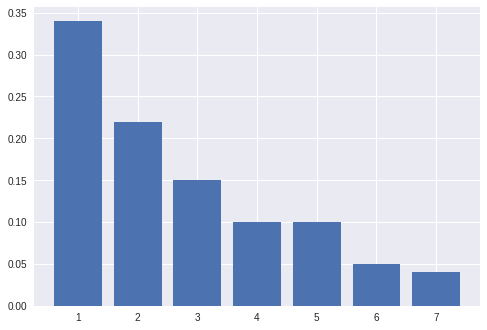

In [0]:
copy_train = train_matrices
copy_test = test_matrices
copy_train_user_data = train_user_data
copy_test_user_data = test_user_data

# How many of the training matrices just have 1 non-row column.
cnt = 0
indices = []
dist = [0, 0, 0, 0, 0, 0, 0]
amnt_dist = [0, 0, 0, 0, 0, 0, 0]
for i in range(len(copy_train)):
    sum_of_matrix = copy_train[i].sum(axis=0)
    nonzeroes = np.nonzero(sum_of_matrix)[0]
    for j in nonzeroes:
        dist[j] += 1
    
    amnt_non_zero = len(nonzeroes)
    amnt_dist[amnt_non_zero-1] += 1
    if amnt_non_zero == 1:
        cnt +=1
        indices.append(i)
# Which days are filled.
plt.bar(range(1, 8), [round(x / len(copy_train), 2) for x in dist])
plt.show()
print(amnt_dist)
plt.bar(range(1, 8), [round(x / len(copy_train), 2) for x in amnt_dist])
plt.show()


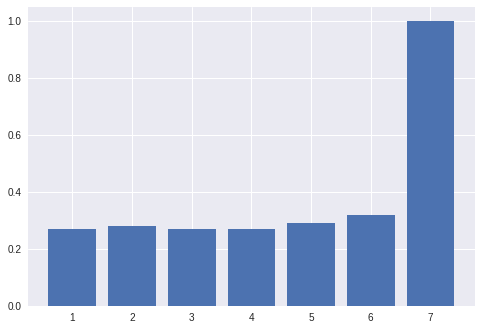

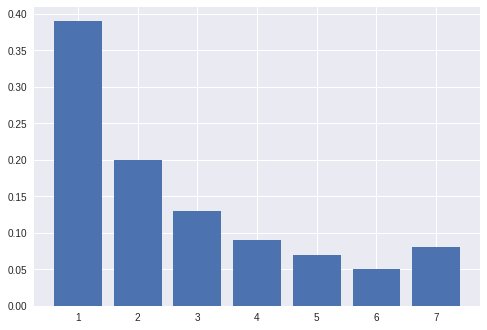

In [0]:
# How many of the training matrices just have 1 non-row column.
cnt = 0
indices = []
dist = [0, 0, 0, 0, 0, 0, 0]
amnt_dist = [0, 0, 0, 0, 0, 0, 0]

for i in range(len(copy_test)):
    sum_of_matrix = copy_test[i].sum(axis=0)
    nonzeroes = np.nonzero(sum_of_matrix)[0]
    for j in nonzeroes:
        dist[j] += 1
    
    amnt_non_zero = len(nonzeroes)
    amnt_dist[amnt_non_zero-1] += 1
    if amnt_non_zero == 1:
        cnt +=1
        indices.append(i)
plt.bar(range(1, 8), [round(x / len(copy_test), 2) for x in dist])
plt.show()

plt.bar(range(1, 8), [round(x / len(copy_test), 2) for x in amnt_dist])
plt.show()

In [0]:
# train_matrices = np.delete(copy_train, indices, axis=0)
# train_classes = np.delete(train_classes, indices)
# train_user_data = np.delete(train_user_data, indices, axis=0)
# train_dates = np.delete(train_dates, indices)
# train_matrices.shape, train_classes.shape, train_user_data.shape

((63241, 25, 7), (63241,), (63241, 8))

## Check distribution of user-data to find important users.

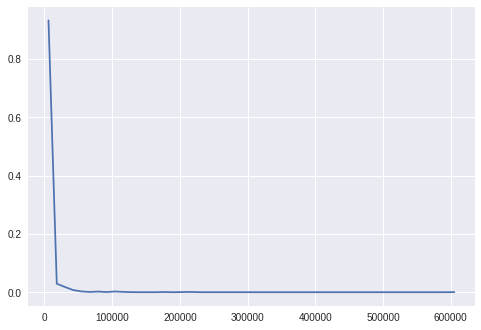

In [0]:
'''
TODO: find important users and filter entire dataset, including test set based on
those userIds. So every user that occurs in the test set, should also occur in 
training set. Else, it's removed.

Perhaps that should be my main criteria, not the amount of followers.
'''
# [['verified', 'followers_count', 'friends_count',
#                                'listed_count', 'favourites_count', 'statuses_count', 'unix_months',
#                                'twitter_user_id']]


# Histogram
heights,bins = np.histogram(copy_train_user_data[:, 1],bins=50)

# Normalize
heights = heights/float(sum(heights))
binMids=bins[:-1]+np.diff(bins)/2.
plt.plot(binMids,heights)

In [0]:
perc = 10
indices = np.argwhere(train_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((129519, 200, 7), (129519,), (129519, 8))

In [0]:
indices = np.argwhere(test_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

test_matrices = np.delete(test_matrices, indices, axis=0)
test_classes_t = np.delete(test_classes_t, indices)
test_user_data = np.delete(test_user_data, indices, axis=0)
test_dates = np.delete(test_dates, indices)
test_matrices.shape, test_classes_t.shape, test_user_data.shape,test_dates.shape

((18133, 200, 7), (18133,), (18133, 8), (18133,))

## See which test users are not in train NOTE: SHOULD REMOVE FROM BOTH SIDES.

In [36]:
indices = []
test_user_ids = np.unique(test_user_data[:,-1])
for i in range(len(train_user_data[:,-1])):
    if train_user_data[i,-1] not in test_user_ids:
        indices.append(i)
        
len(indices) / len(train_user_data[:,-1])

0.0

In [13]:
train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_classes = np.delete(train_classes, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_btc_meta_data = np.delete(train_btc_meta_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((15275, 1000, 7), (15275,), (15275, 8))

### Compare occurences users training versus test set

In [0]:
unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

cnt_train, cnt_test

({-1.8449034827976734: 8,
  -1.8379357715339544: 1,
  -1.8191229511219125: 44,
  -1.8121552398581933: 1,
  -1.8079746130999619: 5,
  -1.8017036729626146: 7,
  -1.7877682504351762: 1,
  -1.7856779370560605: 19,
  -1.780103768045085: 32,
  -1.7794069969187132: 21,
  -1.7752263701604816: 17,
  -1.7612909476330432: 2,
  -1.7592006342539275: 1,
  -1.7515361518638364: 13,
  -1.7417813560946296: 1,
  -1.7403878138418856: 1,
  -1.7396910427155137: 4,
  -1.7257556201880755: 2,
  -1.7243620779353315: 47,
  -1.7111234265342652: 7,
  -1.6992783173859425: 63,
  -1.6902202927431076: 6,
  -1.686039665984876: 19,
  -1.685342894858504: 20,
  -1.6804654969739006: 13,
  -1.6790719547211568: 10,
  -1.677678412468413: 22,
  -1.6721042434574376: 1,
  -1.6707107012046938: 4,
  -1.6700139300783219: 3,
  -1.6651365321937184: 26,
  -1.6623494476882308: 1,
  -1.6616526765618589: 1,
  -1.660955905435487: 67,
  -1.660259134309115: 2,
  -1.6595623631827432: 19,
  -1.650504338539908: 62,
  -1.6498075674135362: 10,
 

## See which train users are not in test

In [14]:
indices = []
train_user_ids = np.unique(train_user_data[:,-1])
for i in range(len(test_user_data[:,-1])):
    if test_user_data[i,-1] not in train_user_ids:
        indices.append(i)
        
len(indices) / len(test_user_data[:,-1])

0.305801060581713

In [15]:
test_matrices = np.delete(test_matrices, indices, axis=0)
test_classes_t = np.delete(test_classes_t, indices)
test_classes = np.delete(test_classes, indices)
test_user_data = np.delete(test_user_data, indices, axis=0)
test_btc_meta_data = np.delete(test_btc_meta_data, indices, axis=0)
test_dates = np.delete(test_dates, indices)
test_matrices.shape, test_classes_t.shape, test_user_data.shape

((4320, 1000, 7), (4320,), (4320, 8))

### Compare occurences users training versus test set

In [0]:
'''
NOTE: Amount of occurences is SUPER low, so I'm pretty sure we can't map any 
relevant information for a user.
'''

unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

list_users_occ = [k for k,v in cnt_train.items() if v > 10]
list_users_occ, cnt_train

([8.39137366786943e-05,
  0.0009230511034656374,
  0.0013426197868591089,
  0.001678274733573886,
  0.0028530670470756064,
  0.0034404632038264665,
  0.0037761181505412437,
  0.004363514307292104,
  0.004699169254006881,
  0.005034824200721658,
  0.005118737937400353,
  0.00545439288411513,
  0.005873961567508601,
  0.005957875304187296,
  0.00604178904086599,
  0.0062096165142233786,
  0.006964840144331627,
  0.008223546194512042,
  0.009230511034656374,
  0.009314424771335067,
  0.009398338508013762,
  0.009817907191407233,
  0.01015356213812201,
  0.010405303348158094,
  0.010740958294872871,
  0.010824872031551564,
  0.01090878576823026,
  0.010992699504908953,
  0.011412268188302425,
  0.011496181924981119,
  0.012167491818410673,
  0.012587060501804146,
  0.01367793907862717,
  0.014181421498699337,
  0.014600990182092809,
  0.015188386338843668,
  0.015272300075522363,
  0.016279264915666693,
  0.016447092389024084,
  0.01653100612570278,
  0.01661491986238147,
  0.0169505748090

# Device config


In [16]:
# Device configuration
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# Process data and set parameters

In [0]:
np.unique(test_classes)

array([0, 1])

In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories='auto')
enc.fit(train_classes_t.reshape(-1, 1))

# 3. Transform
train_classes_t = enc.transform(train_classes_t.reshape(-1, 1)).toarray()
test_classes_t = enc.transform(test_classes_t.reshape(-1, 1)).toarray()

## Check class imbalance

In [0]:
cnt_1, cnt_2, cnt_3 = 0, 0, 0
for i in test_classes_t:
    j = list(i)
    if j == [1, 0, 0]:
        cnt_1+=1
    elif j == [0, 1, 0]:
        cnt_2+=1
    elif j == [0, 0, 1]:
        cnt_3+=1
        
cnt_1/ len(test_classes_t), cnt_2/ len(test_classes_t), cnt_3 / len(test_classes_t)

(0.4962962962962963, 0.27291666666666664, 0.23078703703703704)

In [0]:
test_classes_t.shape, test_matrices.shape, 

((36380, 3), (6223, 1000, 7))

# Model

In [0]:
# Hyper parameters
num_epochs = 50
num_classes = 1#3#1
multi_class = False
batch_size = 128
learning_rate = 0.1
size_user_info = 8

# print('''Occurences of zero/one vs total amount of 
# classes for train and test set:
# -------------------------------''')
# for d in [train_classes, test_classes]:
#     occ_zero = len([x for x in d if x == 0])
#     occ_one = len(d) - occ_zero
#     print(occ_one, occ_zero, len(d))

tensor_1 = torch.from_numpy(train_matrices)
tensor_2 = torch.from_numpy(train_classes)#_t)#train_classes)
tensor_3 = torch.from_numpy(train_user_data.astype(float))
tensor_4 = torch.from_numpy(train_dates.astype(float))
tensor_5 = torch.from_numpy(train_btc_meta_data.astype(float))

full_dataset = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)

tensor_1 = torch.from_numpy(test_matrices)
tensor_2 = torch.from_numpy(test_classes)#_t)#test_classes)
tensor_3 = torch.from_numpy(test_user_data.astype(float))
tensor_4 = torch.from_numpy(test_dates.astype(float))
tensor_5 = torch.from_numpy(test_btc_meta_data.astype(float))

test = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4, tensor_5)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=False)

In [0]:
test_btc_meta_data[]

array([-0.491085  , -0.51564717, -0.4111719 , -0.46705854, -0.66236714,
       -0.55232488,  0.13133077,  1.12477298])

## Setup Model

In [0]:
# # https://github.com/rodgzilla/machine_learning_pytorch_simple_cnn_1d_nlp/blob/master/notebooks/CNN%201D.ipynb
# class ConvNet(nn.Module):
#     def __init__(self, num_classes):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv1d(25, 32, kernel_size=5, stride=1, padding=2) #prev was 25, 12, 5
#         self.conv2 = nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(5*16, 32)
#         self.bn1 = nn.BatchNorm1d(32)
#         self.fc2 = nn.Linear(32, 16)
#         self.bn2 = nn.BatchNorm1d(16)
#         self.fc3 = nn.Linear(16, num_classes) #+ size_user_info, num_classes)
#         self.out_act = nn.Sigmoid()

#     def forward(self, x, user_data):
#         x = x.view(batch_size, 25, 7).float()
#         #print(x.shape)
#         x = F.relu(self.conv1(x))
#         #print(x.shape)
#         x = F.relu(self.conv2(x))
#         #print(x.shape)
#         x = F.relu(self.conv3(x))
#         #print(x.shape)
#         x = x.view(x.shape[0], -1)
#         #print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         #x = torch.cat((x, user_data.float()), 1)
#         x = self.fc3(x)
#         x = self.out_act(x)
#         return x.view(-1, batch_size).squeeze()

# https://github.com/rodgzilla/machine_learning_pytorch_simple_cnn_1d_nlp/blob/master/notebooks/CNN%201D.ipynb
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(INPUT_SIZE_CNN, 256, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(5*64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32 + size_user_info, num_classes)
        self.out_act = nn.Sigmoid()

    def forward(self, x, user_data, btc_meta_data):
        #print(x.shape, btc_meta_data.shape)
        #x = torch.cat((x, btc_meta_data), 0)
        #print(x.shape)
        x = x.view(batch_size, INPUT_SIZE_CNN, 7).float()
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #x = self.bn1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        x = torch.cat((x, user_data.float()), 1)
        x = self.fc3(x)
        x = self.out_act(x)
        #print(x)
        return x


model = ConvNet(num_classes).to(device)

#criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

1527241

## (Optional) Load model

In [0]:
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc'
model = model.load_state_dict(torch.load('{}/model_{}_{}_{}.ckpt'.format(
    base_str, num_epochs, batch_size, 'cluster')))


NameError: ignored

## Methods

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

def validate_model(val_loader, multi_class):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        losses = []
        for images, labels, user_data, dates, btc_meta_data in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data)
            if multi_class:
                loss = criterion(outputs, torch.max(labels, 1)[1])
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                loss = criterion(outputs, labels.float())
                pred.extend(outputs.data.cpu().numpy())
                y.extend(labels.data.cpu().numpy())
            losses.append(loss.data.cpu().numpy())
            
        losses = np.mean(losses)
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = average_precision_score(y, pred)

        print('Epoch [{}/{}], val MAP/acc: {}, val loss: {}'
              .format(epoch + 1, num_epochs, auc, losses))
        return losses, auc

def train_model(train_loader, multi_class):
    losses = []
    pred = []
    y = []
    for i, (images, labels, user_data, dates, btc_meta_data) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data)
        
        
        if multi_class:
            loss = criterion(outputs, torch.max(labels, 1)[1])
            pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
            y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
        else:
            loss = criterion(outputs, labels.float())
            pred.extend(outputs.data.cpu().numpy())
            y.extend(labels.data.cpu().numpy())
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.cpu().numpy())
        
        if i % int(len(train_loader) / 3)  == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, np.mean(losses)))

    if multi_class:
        auc = accuracy_score(y, pred)
    else:
        auc = average_precision_score(y, pred)

    return np.mean(losses), auc

def test_model(test_loader, multi_class):
    model.eval()
    with torch.no_grad():
        pred = []
        y = []
        for images, labels, user_data, dates, btc_meta_data in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            btc_meta_data = btc_meta_data.to(device)
            outputs = model(images, user_data, btc_meta_data)
            if multi_class:
                pred.extend(torch.max(outputs, 1)[1].data.cpu().numpy())
                y.extend(torch.max(labels, 1)[1].data.cpu().numpy())
            else:
                pred.extend(outputs.data.cpu().numpy())
                y.extend(labels.data.cpu().numpy())
            
      
        if multi_class:
            auc = accuracy_score(y, pred)
        else:
            auc = average_precision_score(y, pred)

        print('Test MAP: '.format(auc))
        return auc

## K-Fold CV

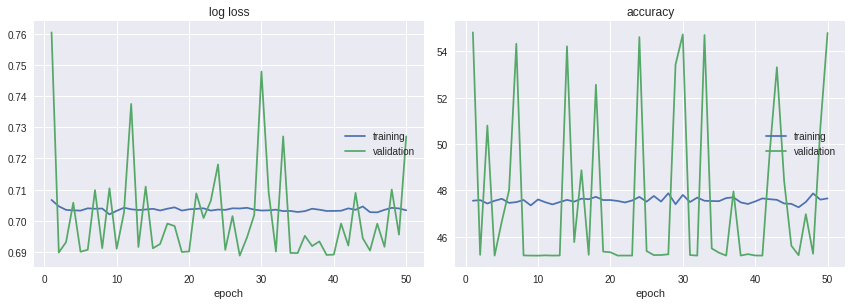

log loss:
training   (min:    0.702, max:    0.707, cur:    0.703)
validation (min:    0.689, max:    0.760, cur:    0.727)

accuracy:
training   (min:   47.266, max:   47.872, cur:   47.650)
validation (min:   45.178, max:   54.821, cur:   54.797)
Final validation loss for current fold: 0.7270606756210327
-------------------------------
2-fold validation has been executed, mean validation loss: 0.7112228870391846


In [0]:
# Train the model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       verbose=True, patience=8)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)
fold_val_losses = []
saved_plots = []
file_name_base = '/content/gdrive/My Drive/Colab Notebooks/data/btc/plots/{}_fold_'.format(time.time())
fold = 0
for train_indexes, validation_indexes in kf.split(full_dataset):
    fold += 1
    liveloss = PlotLosses(save_img=True, file_name=file_name_base + str(fold) + '.png')

    train = torch.utils.data.dataset.Subset(full_dataset, train_indexes)
    validation = torch.utils.data.dataset.Subset(full_dataset, validation_indexes)
    
    model = ConvNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Set train and validation data loaders.
    train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               drop_last=True,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=validation,
                                              batch_size=batch_size,
                                              drop_last=True,
                                              shuffle=True)
    total_step = len(train_loader)
    print('-------------------------------')
    print('Starting training for new fold')
    print('-------------------------------')
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(train_loader)
        val_loss, val_acc = validate_model(val_loader)
        scheduler.step(val_loss)
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': val_loss,
            'accuracy': train_acc,
            'val_accuracy': val_acc
        })
        liveloss.draw()
    
    print('Final validation loss for current fold: {}'.format(val_loss))
    fold_val_losses.append(val_loss)
    saved_plots.append(liveloss)
    
print('-------------------------------')
print('{}-fold validation has been executed, mean validation loss: {}'.
      format(n_folds, np.mean(fold_val_losses)))

np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/plots_crossval_{}_{}_{}.npy'.
        format(num_epochs, batch_size, time.time()), np.array(saved_plots))

### Note: unfortunately the function above overwrites older plots. However, I've saved them into the list below. So you can access them by simply accessing the corresponding index.

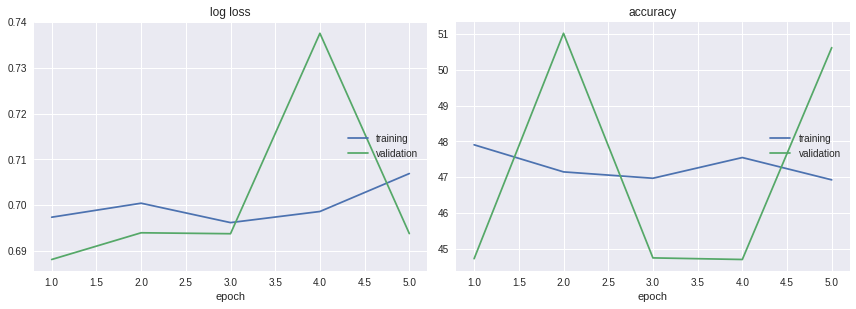

log loss:
training   (min:    0.696, max:    0.707, cur:    0.707)
validation (min:    0.688, max:    0.738, cur:    0.694)

accuracy:
training   (min:   46.925, max:   47.906, cur:   46.925)
validation (min:   44.697, max:   51.025, cur:   50.624)


In [0]:
saved_plots[1].draw()


## Train and test final model

In [0]:
'''
Thus far best with lr=0.001 and Adam, no reduceLronplateau yet and batch_size 32.

Seems to work better without user-data, could be due to the sheer amount of user-data
in respective training/validation/test sets. E.g. User A might be very present in training set, but not so much in validation/test set.

When removing users with a lower than 25th percentile amount of followers doesn't help.
'''

# Init model
model = ConvNet(num_classes).to(device)
criterion = nn.BCELoss()#.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)#

# Set train and validation data loaders.
len_train = int(len(full_dataset) * 0.8)
len_val = len(full_dataset) - len_train

train, validation = torch.utils.data.dataset.random_split(full_dataset, [len_train, len_val])


train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           drop_last=True,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=True)

total_step = len(train_loader)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                      verbose=True, patience=5)

train_losses, train_aucs, val_losses, val_aucs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_auc = train_model(train_loader, multi_class)
    val_loss, val_auc = validate_model(val_loader, multi_class)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_aucs.append(val_aucs)
    print('At end of epoch, average (training) loss: {}, MAP: {} '.format(train_loss, train_auc))
    print('At end of epoch, average (validation) loss: {}, MAP: {} '.format(val_loss, val_auc))
    scheduler.step(val_loss)

acc = test_model(test_loader, multi_class)

# Save the model checkpoint
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/model_{}_{}_{}_{}_{}.ckpt'.format(
    num_epochs, batch_size, model_type, acc, time.time()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/50], Step [1/95], Loss: 0.7019
Epoch [1/50], Step [32/95], Loss: 0.6992
Epoch [1/50], Step [63/95], Loss: 0.6939
Epoch [1/50], Step [94/95], Loss: 0.6914
Epoch [1/50], val MAP/acc: 0.44072451911714133, val loss: 0.688809871673584
At end of epoch, average (training) loss: 0.6915948987007141, MAP: 0.4273145966360818 
At end of epoch, average (validation) loss: 0.688809871673584, MAP: 0.44072451911714133 
Epoch [2/50], Step [1/95], Loss: 0.6708
Epoch [2/50], Step [32/95], Loss: 0.6514
Epoch [2/50], Step [63/95], Loss: 0.6471
Epoch [2/50], Step [94/95], Loss: 0.6466
Epoch [2/50], val MAP/acc: 0.4727216231485973, val loss: 0.7158942222595215
At end of epoch, average (training) loss: 0.6465239524841309, MAP: 0.5702969619974787 
At end of epoch, average (validation) loss: 0.7158942222595215, MAP: 0.4727216231485973 
Epoch [3/50], Step [1/95], Loss: 0.5527
Epoch [3/50], Step [32/95], Loss: 0.5009
Epoch [3/50], Step [63/95], Loss: 0.5091
Epoch [3/50], Step [94/95], Loss: 0.5278
Epoch [

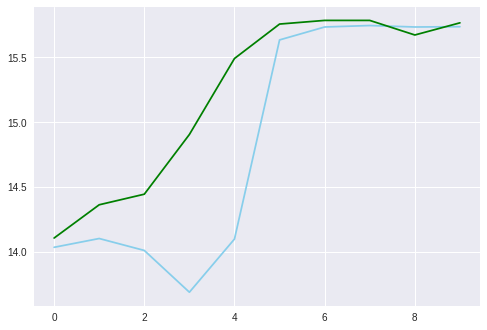

In [31]:
# Make plot.
plt.plot(train_losses, color='skyblue')
plt.plot(val_losses, color='green')
plt.show()

In [0]:
plt.plot(train_aucs, color='skyblue')
plt.plot(val_aucs, color='green')
plt.show()

In [0]:
acc = test_model(test_loader)
acc

Test MAP of the model on the test images: 0.37863565939093846%


0.3828954766654051

# Trading strategy

## Perform forward pass on training set to generate data for Logistic Regression and majority vote

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size, shuffle=False, drop_last=True)
train_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        outputs = model(images, user_data)
        #predicted = (0.5 > outputs).float() * 1
        #predicted = torch.max(outputs, 1)[1].data.cpu().numpy()
        #print(predicted)
        #labels = torch.max(labels, 1)[1].data.cpu().numpy()
        #print(predicted)
        #predicted = np.array([x[0] for x in predicted.data.cpu().numpy()])
        outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
        #labels = np.array([x for x in labels.data.cpu().numpy()])
        
        temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if train_lr is None:
            train_lr = temp
        else:
            train_lr = np.concatenate((train_lr, temp), axis=0)

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, drop_last=True)
test_lr = None
outp = []
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

multi_class = False
with torch.no_grad():
    for images, labels, user_data, dates, btc_meta_data in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        btc_meta_data = btc_meta_data.to(device)
        outputs = model(images, user_data, btc_meta_data)
        
        if multi_class:
            predicted = torch.max(outputs, 1)[1].data.cpu().numpy()
            labels = torch.max(labels, 1)[1].data.cpu().numpy()
            temp = np.dstack((outputs, labels, user_data.data.cpu().numpy()[:,-1],
                           dates.data.cpu().numpy(), predicted)).squeeze()
            temp = np.dstack((outputs, temp))
        else:
            outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
            temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        
        if test_lr is None:
            test_lr = temp
        else:
            test_lr = np.concatenate((test_lr, temp), axis=0)

torch.Size([32, 1000, 7]) torch.Size([32, 8])


RuntimeError: ignored

In [0]:
test_lr[0]

array([ 4.03641909e-01,  0.00000000e+00, -1.60807670e-01,  1.78420000e+04,
        0.00000000e+00])

## Create dataframe for LR and MV

In [0]:
import pandas as pd

if multi_class:
    train_df = pd.DataFrame({'output1':train_lr[:,0], 'output2':train_lr[:,1], 'output3':train_lr[:,2], 'true':train_lr[:,3], 
                                   'user':train_lr[:,4], 'date':train_lr[:,5], 'pred_max':train_lr[:,6]})
    test_df = pd.DataFrame({'output1':test_lr[:,0], 'output2':test_lr[:,1], 'output3':test_lr[:,2], 'true':test_lr[:,3], 
                                   'user':test_lr[:,4], 'date':test_lr[:,5], 'pred_max':test_lr[:,6]})
else:
    train_df = pd.DataFrame({'output':train_lr[:,0],'true':train_lr[:,1], 
                                       'user':train_lr[:,2], 'date':train_lr[:,3], 'pred_max':train_lr[:,4]})
    test_df = pd.DataFrame({'output':test_lr[:,0],'true':test_lr[:,1], 
                                       'user':test_lr[:,2], 'date':test_lr[:,3], 'pred_max':test_lr[:,4]})

In [0]:
import pandas as pd



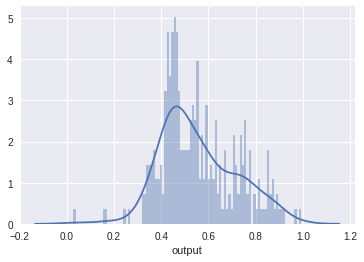

In [0]:
import seaborn 

seaborn.distplot(train_df['output'][train_df['date'] == 17548.0], bins=100)

## Perform Majority Vote and predict mean per date

In [0]:
data_MV = train_df[['date', 'output', 'true', 'pred_max']]
cnt_MV = 0
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
score = 0
for i in range(35, 75):
    threshold = i / 100
    cnt_MV = 0
    cnt_max = 0
    pairs = []
    for date in dates:
        temp = data_MV[data_MV['date'] == date]
        y_true = temp['true'].unique()[0]
        MV = temp['pred_max'].value_counts().index[0]
        max_all = temp['output'].mean()
        max_all = 1 if max_all >= threshold else 0

        if y_true == MV:
            cnt_MV += 1
        if y_true == max_all:
            cnt_max += 1
            #print('correct', y_true, temp['output'].mean())
        else:
            #print('wrong', y_true, temp['output'].mean())
            pairs.append([max_all, y_true])
    new_score = cnt_max / len(dates)
    if new_score > score:
        best_thresh = threshold
        score = new_score
print('The best score was {} with threshold {}'.format(score, best_thresh))
print('Performing MV resulted in an acc of: {}'.format(cnt_MV / len(dates)))

The best score was 0.986 with threshold 0.48
Performing MV resulted in an acc of: 0.538


## Use best threshold for training set on test set to measure performance

correct 0.0 0.4642813477446685
correct 0.0 0.3940351369502256
correct 0.0 0.3582738183733526
correct 0.0 0.28805862039554586
correct 0.0 0.3428268909855845
correct 0.0 0.3965358716203886
correct 0.0 0.33541154722431227
correct 0.0 0.47043572962454494
correct 0.0 0.44460945155046383
correct 0.0 0.4309445042309995
wrong 1.0 0.4721165751275007
correct 0.0 0.4084576045191588
correct 0.0 0.44115551394780883
wrong 1.0 0.42921858266133206
correct 0.0 0.439228242081075
correct 1.0 0.4811767234791668
correct 0.0 0.4052750864696556
wrong 1.0 0.3982421987443244
correct 0.0 0.45192239051497085
wrong 1.0 0.4754121744281286
wrong 1.0 0.4013895578506346
wrong 1.0 0.3706165139650302
correct 0.0 0.4027615991879523
correct 1.0 0.4971364849125908
correct 0.0 0.3909890212997605
correct 0.0 0.4058591790817636
wrong 1.0 0.36916805845974027
correct 0.0 0.42663310627787626
correct 0.0 0.4300669013642334
correct 0.0 0.3550942734914665
The score on the test set is: 0.7666666666666667 with threshold 0.48
7 0 7


Text(0.5,257.44,'Predicted label')

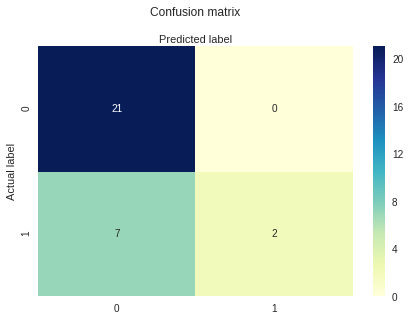

In [0]:
data_MV = test_df[['date', 'output', 'true', 'pred_max']]
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
y_train = []
y_pred = []
for date in dates:
    temp = data_MV[data_MV['date'] == date]
    y_true = temp['true'].unique()[0]
    MV = temp['pred_max'].value_counts().index[0]
    max_all = temp['output'].mean()
    max_all = 1 if max_all > best_thresh else 0
    y_train.append(y_true)
    y_pred.append(max_all)
    if y_true == max_all:
        cnt_max += 1
        print('correct', y_true, temp['output'].mean())
    else:
        print('wrong', y_true, temp['output'].mean())
        pairs.append([max_all, y_true])

print('The score on the test set is: {} with threshold {}'.format(cnt_max / len(dates), best_thresh))
print(len(pairs), len([x for x in pairs if x[0] == 1]), len([x for x in pairs if x[0] == 0]))
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Create required dataset for Logistic Regression

In [0]:
'''
For logistic regression we'd the following input:
[user_pred_1, .... user_pred_n]

We create a matrix with all zeroes and replace the user predictions if there
are any. If there's none, then we simply leave it at zero.

So we get a matrix per day with predictions for all users.
'''


# # Get all users
train_users = train_df['user'].unique()
test_users = test_df['user'].unique()
# print(train_users)
# print(test_users)
users = np.concatenate((train_users, test_users))
# # Assign users a unique id from 0 to n unique ids, 
# # create a dictionairy using training data and re-use during test time.
user_ids_lr = {}
for i, v in enumerate(users):
    user_ids_lr[v] = i

# Loop over dates, check if user has prediction
X_train = None
y_train = []
cnt = 0
for date in train_df['date'].unique():
    cnt += 1
    temp = train_df[train_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        arr[user_ids_lr[usr]] = pred
    y_train.append([lbl])
    if X_train is None:
        X_train = arr
    else:
        X_train = np.vstack((X_train, arr))

y_train = np.array(y_train)  

In [0]:
# Loop over dates, check if user has prediction
X_test = None
y_test = []
cnt = 0
cnt_n = 0
for date in test_df['date'].unique():
    cnt += 1
    temp = test_df[test_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        try:
            arr[user_ids_lr[usr]] = pred
        except:
            #print('User {} not found'.format(usr))
            cnt_n += 1
    y_test.append([lbl])
    if X_test is None:
        X_test = arr
    else:
        X_test = np.vstack((X_test, arr))

y_test = np.array(y_test)  
cnt_n / cnt 

0.0

## Perform Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression


# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.9)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

# Predict on test
y_pred = logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 7, 14],
       [ 2,  7]])

array([[ 5, 16],
       [ 2,  7]])

Text(0.5,257.44,'Predicted label')

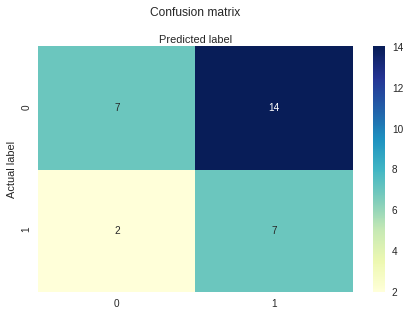

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')